In [1]:
from mohan.Similarity import Similarity
from mohan.ColavSimilarity import parse_doi, parse_string
from joblib import Parallel, delayed
import pickle
import numpy as np
from mohan.ColavSimilarity import ColavSimilarity, parse_doi, parse_string
from elasticsearch import Elasticsearch, __version__ as es_version
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:

from mohan.ColavSimilarity import ColavSimilarity, parse_string
from elasticsearch import Elasticsearch, __version__ as es_version
from elasticsearch.helpers import bulk


class Similarity:
    def __init__(self, es_index, es_uri: str = "http://localhost:9200",
                 es_auth: tuple = ('elastic', 'colav'),
                 es_req_timeout: int = 120):
        """
        Initialize the Similarity class.
        Parameters:
        -----------
        es_index: str 
                name of the index
        es_uri: str 
                uri of the elastic search server
        es_auth: tuple 
                authentication for the elastic search server
        es_req_timeout: int 
                elastic search request timeout
        """
        auth = es_auth
        if es_version[0] < 8:
            self.es = Elasticsearch(
                es_uri, http_auth=auth, timeout=es_req_timeout)
        else:
            self.es = Elasticsearch(
                es_uri, basic_auth=auth, timeout=es_req_timeout)
        self.es_index = es_index
        self.es_req_timeout = es_req_timeout

    def create_index(self, mapping: dict = None, recreate: bool = False):
        """
        Create an index.
        Parameters:
        -----------
        index_name: str name of the index
        mapping: dict mapping of the index
        recreate: bool whether to recreate the index or not

        """
        if recreate:
            if self.es.indices.exists(index=self.es_index):
                self.delete_index(self.es_index)
        if mapping:
            self.es.indices.create(index=self.es_index, body=mapping)
        else:
            self.es.indices.create(index=self.es_index)

    def delete_index(self, index_name: str):
        """
        Delete an index.
        Parameters:
        -----------
        index_name: str name of the index
        """
        self.es.indices.delete(index=index_name)

    def insert_work(self, _id: str, work: dict):
        """
        Insert a work into the index.
        work should have a dict structure like the next one.
        work = {"title": "title of the work",
                "authors": "authors of the work",
                "source": "source of the work",
                "year": "year of the work",
                "volume": "volume of the work",
                "issue": "issue of the work",
                "page_start": "page start of the work",
                "page_end": "page end of the work"}
        every value is a string, including the year, volume, issue, page_start and page_end.

        Additional fields such as doi, pmid, pmcid, etc. can be added to the work dict if needed,
        but the search is over the previous fields.

        Parameters:
        -----------
        _id: str id of the work (ex: mongodb id as string)
        work: dict work to be inserted
        """
        return self.es.index(index=self.es_index,  id=_id, document=work)

    def search_work(self, title: str, source: str, year: str,
                    volume: str, issue: str, page_start: str, page_end: str, 
                    use_es_thold: bool = False, es_thold_low: int = 10, es_thold_high: int = 120,
                    ratio_thold: int = 90, partial_thold: int = 95, low_thold: int = 80, parse_title: bool = True):
        """
        Compare two papers to know if they are the same or not.
        Parameters:
        -----------
        title: str 
                title of the paper
        source: str 
                name of the journal in which the paper was published
        year: int 
                year in which the paper was published
        volume: int 
                volume of the journal in which the paper was published
        issue: int 
                issue of the journal in which the paper was published
        page_start: int 
                first page of the paper
        page_end: int 
                last page of the paper
        use_es_thold: bool
                whether to use the elastic search score threshold or not
        es_thold_low: int
                elastic search score threshold to discard some results with lower score values
        es_thold_high: int
                elastic search score threshold to return the best hit
        ratio_thold: int 
                threshold to compare through ratio function in thefuzz library
        partial_ratio_thold: int 
                threshold to compare through partial_ratio function in thefuzz library
        low_thold: int
                threshold to discard some results with lower score values
        es_request_timeout: int
                elastic search request timeout
        parse_title: bool
                whether to parse the title or not (parse title helps to improve the results)

        Returns:
        --------
        record: dict when the papers are (potentially) the same, None otherwise.
        """
        if not isinstance(title, str):
            title = ""

        if not isinstance(source, str):
            source = ""

        if isinstance(volume, int):
            volume = str(volume)

        if isinstance(issue, int):
            issue = str(issue)

        if isinstance(page_start, int):
            page_start = str(page_start)

        if isinstance(page_end, int):
            page_end = str(page_end)

        if not isinstance(volume, str):
            volume = ""

        if not isinstance(issue, str):
            issue = ""

        if not isinstance(page_start, str):
            page_start = ""

        if not isinstance(page_end, str):
            page_end = ""
        if parse_title:
            title = parse_string(title)
            
      
        body = {
            "query": {
                "bool": {
                    "should": [
                        {"match": { "title":  {
                                 "query": title,
                                 "operator": "OR"
                              }}},
                        #{"match": {"title": {"query":  title,"boost": 1}}},
                        # {"match": {"source":  source}},
                        { "match": { "source":  {
                                 "query": source,
                                 "operator": "AND"
                              }}},
                        {"term":  {"year": year}},
                        {"term":  {"volume": volume}},
                        {"term":  {"issue": issue}},
                        {"term":  {"page_start": page_start}},
                        {"term":  {"page_end": page_end}},
                    ]
                }
            },
            "size": 20,
        }

        res = self.es.search(index=self.es_index, **body)
        if res["hits"]["total"]["value"] != 0:
            best_hit = res["hits"]["hits"][0]
            if use_es_thold:
                if best_hit["_score"] < es_thold_low:
                    return None
                if best_hit["_score"] >= es_thold_high:
                    return best_hit

            for i in res["hits"]["hits"]:
                value = ColavSimilarity(title, i["_source"]["title"],
                                        source, i["_source"]["source"],
                                        year, i["_source"]["year"],
                                        ratio_thold=ratio_thold, partial_thold=partial_thold, low_thold=low_thold)
                if value:
                    return i
            return None
        else:
            return None

    def insert_bulk(self, entries: list, refresh=True):
        """
        Insert a bulk of works into the index.
        Parameters:
        -----------
        entries: list 
                list of works to be inserted
        """
        return bulk(self.es, entries, index=self.es_index, refresh=refresh, request_timeout=self.es_req_timeout)


In [3]:
s = Similarity("openalex_parsed",es_uri="172.19.31.8")

In [4]:
# open a file, where you stored the pickled data
file = open('dataset_full.pkl', 'rb')
# dump information to that file
data = pickle.load(file)
# close the file
file.close()

In [288]:

fns = []
fps = []

for i in range(100):
    if i%10 == 0:
        print(i)
    scopus = []
    np.random.shuffle(data["p"])
    np.random.shuffle(data["n"])
    for i in data["p"][0:3000]:
        scopus.append((i,True))
    for i in data["n"][0:3000]:
        scopus.append((i,False))
    np.random.shuffle(scopus) #shuffle is inplace
    results = Parallel(n_jobs=72,backend='threading',verbose=1)(delayed(s.search_work)(rec[0]['Title'],rec[0]['Source title'],rec[0]['Year'],
                     rec[0]['Volume'], rec[0]['Issue'], rec[0]['Page start'], rec[0]['Page end'],
                     use_es_thold = False, es_thold_low = 0, es_thold_high = 180,#) for rec in scopus)
                     ratio_thold = 90, partial_thold = 92, low_thold = 81) for rec in scopus)
    actual = []
    predicted = []
    for i in range(len(results)):
        actual.append(scopus[i][1])
        if results[i] is not None:
            predicted.append(True)
        else:
            predicted.append(False)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    confusion_matrix = np.flip(confusion_matrix)
    fn = confusion_matrix[0][1]*100/(confusion_matrix[0][0]+confusion_matrix[0][1])
    fns.append(fn)
    fp = confusion_matrix[1][0]*100/(confusion_matrix[1][0]+confusion_matrix[1][1])
    fps.append(fp)

0


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.7s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.9s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    8.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   11.9s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   15.6s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   19.9s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   24.6s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:   29.9s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.2s
[Parallel(n_j

10


[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    8.3s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   11.6s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   15.3s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   19.5s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   24.3s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:   29.8s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.7s
[Parallel(n_jobs=64)]: Done 1672

20


[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    8.3s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   11.5s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   15.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   19.3s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   24.1s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:   29.7s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 1672

30


[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    8.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   11.5s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   15.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   19.3s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   24.1s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:   29.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.6s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.9s
[Parallel(n_jobs=64)]: Done 1672

40


[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.4s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    8.4s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   11.6s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   15.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   19.5s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   24.1s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:   29.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.7s
[Parallel(n_jobs=64)]: Done 1672

50


[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.5s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    8.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   11.4s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   15.3s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   19.4s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   24.1s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:   29.7s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.8s
[Parallel(n_jobs=64)]: Done 1672

60


[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.6s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    8.3s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   11.5s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   15.3s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   19.6s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   24.3s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:   30.0s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 1672

70


[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    8.5s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   11.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   15.5s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   19.8s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   24.4s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:   30.0s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.7s
[Parallel(n_jobs=64)]: Done 1672

80


[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.3s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    7.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   11.4s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   15.1s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   19.2s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   23.9s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:   29.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.5s
[Parallel(n_jobs=64)]: Done 1672

90


[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    8.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   11.3s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   15.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   19.4s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   24.0s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:   29.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    3.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 1672

True

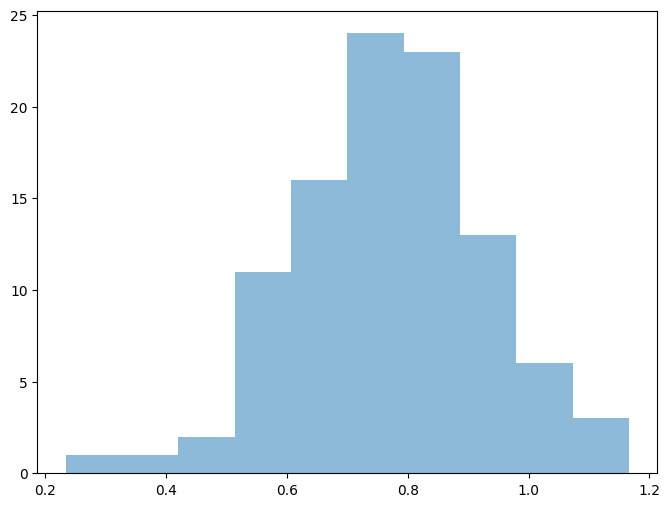

In [289]:
plt.figure(figsize=(8,6))
plt.hist(fns, bins=10, alpha=0.5, label="data1", density=False)
True

True

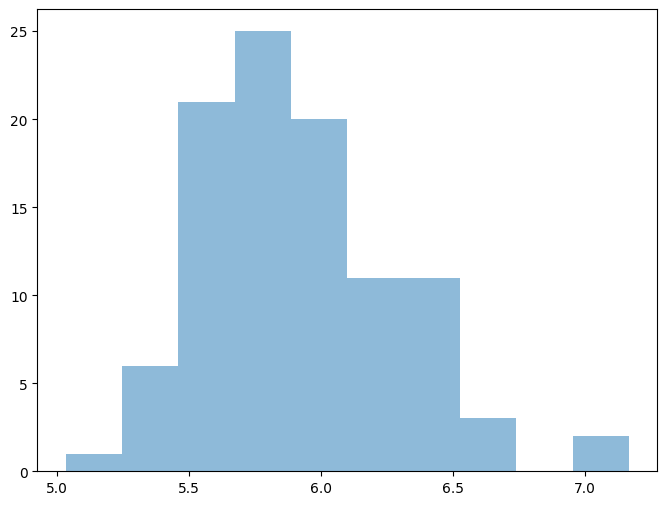

In [290]:
plt.figure(figsize=(8,6))
plt.hist(fps, bins=10, alpha=0.5, label="data1", density=False)
True

In [291]:
#0.71 no ES th
#0.69 boost 1 size =5
np.mean(fns)

0.7659999999999998

In [292]:
np.std(fns)

0.16145037077139907

In [293]:
np.mean(fps)

5.909333333333333

In [294]:
np.std(fps)

0.36588036903398424

In [86]:
with open('similarity_fns_fps_noauthors_ratio_thold95.pkl', 'wb') as f:
    pickle.dump({"fns":fns,"fps":fps}, f)